In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from webcolors import name_to_rgb, hex_to_rgb

def buildField(X, Y, thue_morse):
    ''' Requires size of image
        Returns field'''
    
    FIRST_THUE_MORSE = 0, 0
    
    if not thue_morse:
        x, y = np.random.randint(2, size=X-1, dtype=bool), np.random.randint(2, size=Y-1, dtype=bool)
    else:
        x = np.zeros(X-1, dtype=bool)
        y = np.zeros(Y-1, dtype=bool)
        x[0], y[0] = FIRST_THUE_MORSE
        old, new = 0, 1
        for i in range(1, X-1):
            if i == new:
                old = new
                new <<= 1
            x[i] = not x[i - old]
        old, new = 0, 1
        for i in range(1, Y-1):
            if i == new:
                old = new
                new <<= 1
            y[i] = not y[i - old]

    field = np.zeros((X, Y), dtype=bool)
    for j in range(Y-1):
        field[0, j+1] = field[0, j] ^ y[j]
    zero = np.zeros(Y, dtype=bool)
    ones = np.zeros(Y, dtype=bool)
    for i in range(Y):
        zero[i] = i % 2
        ones[i] = not (i % 2)
    for i in range(X-1):
        if x[i]:
            field[i+1] = np.logical_xor(field[i], ones)
        else:
            field[i+1] = np.logical_xor(field[i], zero)
    return field

def colorMap(field):
    ''' Requires field
        Returns color field and color distribution'''
    X, Y = field.shape
    colmap = np.full((X, Y), -1, dtype=int)
    color_distribution = []
    curcolor = 0
    for i in range(X):
        for j in range(Y):
            if colmap[i, j] == -1:
                color_distribution.append(0)
                curbool = field[i, j]
                stack = [(i, j)]
                while stack:
                    ii, jj = stack.pop()
                    if colmap[ii, jj] == -1:
                        colmap[ii, jj] = curcolor
                        color_distribution[curcolor] += 1
                    if ii > 0     and colmap[ii-1, jj] == -1 and field[ii-1, jj] == curbool:
                        stack.append((ii-1, jj))
                    if ii + 1 < X and colmap[ii+1, jj] == -1 and field[ii+1, jj] == curbool:
                        stack.append((ii+1, jj))
                    if jj > 0     and colmap[ii, jj-1] == -1 and field[ii, jj-1] == curbool:
                        stack.append((ii, jj-1))
                    if jj + 1 < Y and colmap[ii, jj+1] == -1 and field[ii, jj+1] == curbool:
                        stack.append((ii, jj+1))
                curcolor += 1
    return colmap, color_distribution

def graphRegions(color_field, color_dist, num_preferred_colors):
    ''' Requires color field and color distribution
        Returns graph and regions'''
    X, Y = color_field.shape
    m = X * Y
    N = len(color_dist)

    adj = [dict() for _ in range(N)]
    for i in range(X):
        for j in range(1, Y):
            if color_field[i, j-1] != color_field[i, j]:
                adj[color_field[i, j-1]][color_field[i, j]] = 0
                adj[color_field[i, j]][color_field[i, j-1]] = 0
    for i in range(1, X):
        for j in range(Y):
            if color_field[i-1, j] != color_field[i, j]:
                adj[color_field[i-1, j]][color_field[i, j]] = 0
                adj[color_field[i, j]][color_field[i-1, j]] = 0
    graph = [sorted(adj[i]) for i in range(N)]

    def defineAllEdgeValues(parent, vertex):
        sum_child_edges = 0
        for child in adj[vertex]:
            if child != parent:
                defineAllEdgeValues(vertex, child)
                adj[vertex][child] = m - adj[child][vertex]
                sum_child_edges += adj[vertex][child]
        if parent is not None:
            adj[vertex][parent] = m - color_dist[vertex] - sum_child_edges
    defineAllEdgeValues(None, 0)

    def deleteEdges(parent, vertex):
        del_vert = [vertex]
        for child in adj[vertex]:
            if child != parent:
                del_vert.extend(deleteEdges(vertex, child))
        adj[vertex].clear()
        return del_vert
    def updateEdges(upd, parent, vertex):
        adj[vertex][parent] -= upd
        for child in adj[vertex]:
            if child != parent:
                updateEdges(upd, vertex, child)

    if num_preferred_colors == 1:
        color_regions = [(m, list(range(N)))]
    else:
        color_regions = []
        pref = num_preferred_colors
        n = N
        while pref > 1 and n > 1:
            best_approx = m * (pref + 2)
            for i in range(N):
                for j in adj[i]:
                    if abs(m - adj[i][j] * pref) < best_approx:
                        stay, die = i, j
                        best_approx = abs(m - adj[i][j] * pref)
            color_regions.append((adj[stay][die], deleteEdges(stay, die)))
            updateEdges(adj[stay][die], die, stay)
            del adj[stay][die]
            n -= len(color_regions[-1][1])
            m -= color_regions[-1][0]
            pref -= 1
        color_regions.append((m, deleteEdges(None, stay)))
        color_regions.sort(key=lambda x: -x[0])
    return graph, [reg_tup[1] for reg_tup in color_regions]

def defineColorsCube(graph, color_dist, color_regions, preferred_colors):
    ''' Requires graph, color distribution and regions
        Returns decoded colors'''
    
    #################
    # COLOR PHYSICS #
    #################
    
    EPS_MAX_MOTION = 1
    INITIAL_DT = 1.0 / 100
    STOP_ON_DT = 1.5
    INCREASE_DT_ON = 10
    DECREASE_DT_ON = 200
    TIMES_ITERATIONS = 3

    # Border is right
    AXIS_BORDER = 300
    AXIS_INTERCEPT = 60
    AXIS_SLOPE = -AXIS_INTERCEPT / AXIS_BORDER

    ATTR_BORDER = 2000
    ATTR_INTERCEPT = 20
    ATTR_SLOPE = 0.06

    EDGE_REPULSION_BORDER = 50
    EDGE_REPULSION_INTERCEPT = 50
    EDGE_REPULSION_SLOPE = -EDGE_REPULSION_INTERCEPT / EDGE_REPULSION_BORDER

    # Border is left
    EDGE_ATTRACTION_BORDER = 150
    EDGE_ATTRACTION_SLOPE = 0.5
    EDGE_ATTRACTION_INTERCEPT = -EDGE_ATTRACTION_BORDER * EDGE_ATTRACTION_SLOPE
    
    ##########################
    # END OF HYPERPARAMETERS #
    ##########################
    
    norm = np.linalg.norm
    rotation_matrix = 1 / (2 * np.sqrt(3)) * np.array([[1+np.sqrt(3), 1-np.sqrt(3), 2],
                                                       [1-np.sqrt(3), 1+np.sqrt(3), 2],
                                                       [-2, -2, 2]])
    N = len(color_dist)
    converted_preferred_colors = [None] * len(preferred_colors)
    for i in range(len(preferred_colors)):
        if preferred_colors[i][0] == '#':
            r, g, b = hex_to_rgb(preferred_colors[i])
        else:
            r, g, b = name_to_rgb(preferred_colors[i])
        converted_preferred_colors[i] = ((r+0.5)*1000/256, (g+0.5)*1000/256, (b+0.5)*1000/256)
    attr = np.zeros((N, 3))
    for i in range(len(color_regions)):
        for col in color_regions[i]:
            attr[col] = converted_preferred_colors[i]

    acc_zero = np.zeros(3)

    v = np.zeros((N, 3))
    x = np.random.rand(N, 3) * 1000
    dt = INITIAL_DT
    max_motion = [0] * TIMES_ITERATIONS
    max_max_motion = (INCREASE_DT_ON + DECREASE_DT_ON) / 2
    iterations = 0
    while max_max_motion > EPS_MAX_MOTION or dt < STOP_ON_DT:
        w = np.zeros((N, 3))

        # axis repulsion
        direction = x - x.mean(axis=1).reshape(N, 1)
        dir_length = norm(direction, axis=1)
        for i in range(N):
            if dir_length[i] < AXIS_BORDER:
                orig_len = dir_length[i]
                if not dir_length[i]:
                    phi = np.random.rand() * 2 * np.pi
                    direction[i] = rotation_matrix @ np.array([np.cos(phi), np.sin(phi), 0])
                    dir_length[i] = 1.0
                w[i] = direction[i] * ((AXIS_INTERCEPT + AXIS_SLOPE * orig_len) / dir_length[i])

        # color attractor
        direction = attr - x
        dir_length = norm(direction, axis=1)
        for i in range(N):
            if dir_length[i] < ATTR_BORDER:
                orig_len = dir_length[i]
                while not dir_length[i]:
                    direction[i] = np.random.randn(3)
                    dir_length[i] = norm(direction[i])
                w[i] += direction[i] * ((ATTR_INTERCEPT + ATTR_SLOPE * orig_len) / dir_length[i])

        # edge attraction-repulsion
        for i in range(N):
            for j in graph[i]:
                direction = x[i] - x[j]
                dir_length = norm(direction)
                if dir_length > EDGE_ATTRACTION_BORDER:
                    vertices_acc = direction * (-EDGE_ATTRACTION_INTERCEPT / dir_length - EDGE_ATTRACTION_SLOPE)
                elif dir_length > EDGE_REPULSION_BORDER:
                    vertices_acc = acc_zero
                elif dir_length > 0:
                    vertices_acc = direction * (EDGE_REPULSION_INTERCEPT / dir_length + EDGE_REPULSION_SLOPE)
                else:
                    direction = np.random.randn(3)
                    dir_length = norm(direction)
                    while not dir_length:
                        direction = np.random.randn(3)
                        dir_length = norm(direction)
                    vertices_acc = direction * (EDGE_REPULSION_INTERCEPT / dir_length)
                if color_dist[i] > color_dist[j]:
                    vertices_acc *= color_dist[j] / color_dist[i]
                w[i] += vertices_acc

        # MOTION
        v += w * dt
        oldx = x
        x += v * dt
        for vertex in range(N):
            for coord in range(3):
                if x[vertex, coord] < 0.001:
                    x[vertex, coord] = 0.001
                    v[vertex, coord] = 0
                elif x[vertex, coord] > 999.999:
                    x[vertex, coord] = 999.999
                    v[vertex, coord] = 0
        max_motion[iterations % TIMES_ITERATIONS] = norm(x - oldx, axis=1).max()
        iterations += 1
        if not (iterations % TIMES_ITERATIONS):
            max_max_motion = max(max_motion)
            if max_max_motion > DECREASE_DT_ON:
                dt /= 2
            elif max_max_motion < INCREASE_DT_ON:
                dt *= 2
    x = (x * 256 / 1000).astype(int)
    return [tuple(color) for color in x]

def drawByPyplot(color_field, decoded_colors, preferred_colors, save):
    ''' Requires color field and decoded colors
        Draws image'''
    plt.rcParams["figure.figsize"] = (20,20)
    plt.axis("off")
    im_array = [[decoded_colors[int(cell)] for cell in row] for row in color_field]
    plt.imshow(im_array, interpolation="nearest")
    if save:
        random_stuff = str(hex(randint(0, 18446744073709551615))[2:])
        random_stuff = '0' * (16 - len(random_stuff)) + random_stuff
        strname = f"Hitomezashi_{color_field.shape[0]}x{color_field.shape[1]}_{','.join(preferred_colors)}_{random_stuff}.png"
        plt.savefig(strname)

def HitomezashiColoring(X, Y, preferred_colors, save=True, twocolors=False, thue_morse=False):
    ''' Creates image of Hitomezashi stitch patterns with coloring
        X, Y - size of image in pixels
        preferred_colors - list of str's - names or hex-codes of colors, preferred to be in image
            (if twocolors is True then only first two colors will be considered)
        save - bool, whether you want to save image in png
        twocolors - patterns will be colored in only two given colors
        thue_morse - if sequences, that create stitch patterns are thue_morse sequences
            (if True and twocolors is False, then the image will be mostly one-colored)'''
    if twocolors:
        decode = []
        for clr in preferred_colors:
            if clr[0] == '#':
                decode.append(hex_to_rgb(clr))
            else:
                decode.append(name_to_rgb(clr))
        field = buildField(X, Y, thue_morse)
        drawByPyplot(field, decode[:2], preferred_colors[:2], save)
    else:
        field, dist = colorMap(buildField(X, Y, thue_morse))
        graph, regions = graphRegions(field, dist, len(preferred_colors))
        decode = defineColorsCube(graph, dist, regions, preferred_colors)
        drawByPyplot(field, decode, preferred_colors, save)

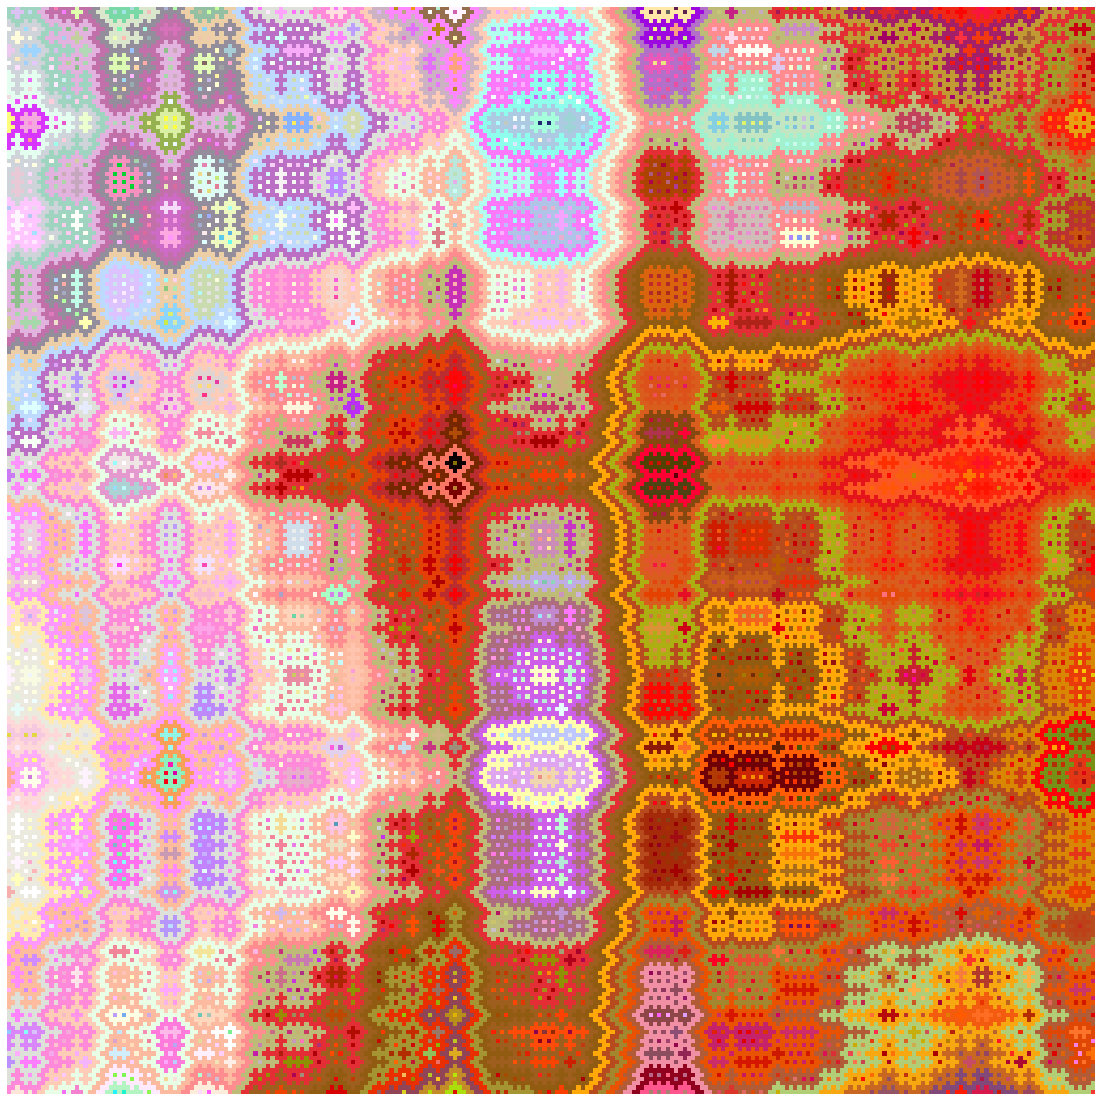

In [3]:
HitomezashiColoring(256, 256, ["red", "white"])